In [12]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML
# Load data
weekly_df = pd.read_csv('Weekly.csv')

# Check for missing data
assert weekly_df.isnull().sum().sum() == 0

# Pre-processing
weekly_df = pd.get_dummies(weekly_df).drop('Direction_Down', axis=1)
weekly_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,False
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,False
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,True
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,True
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,True


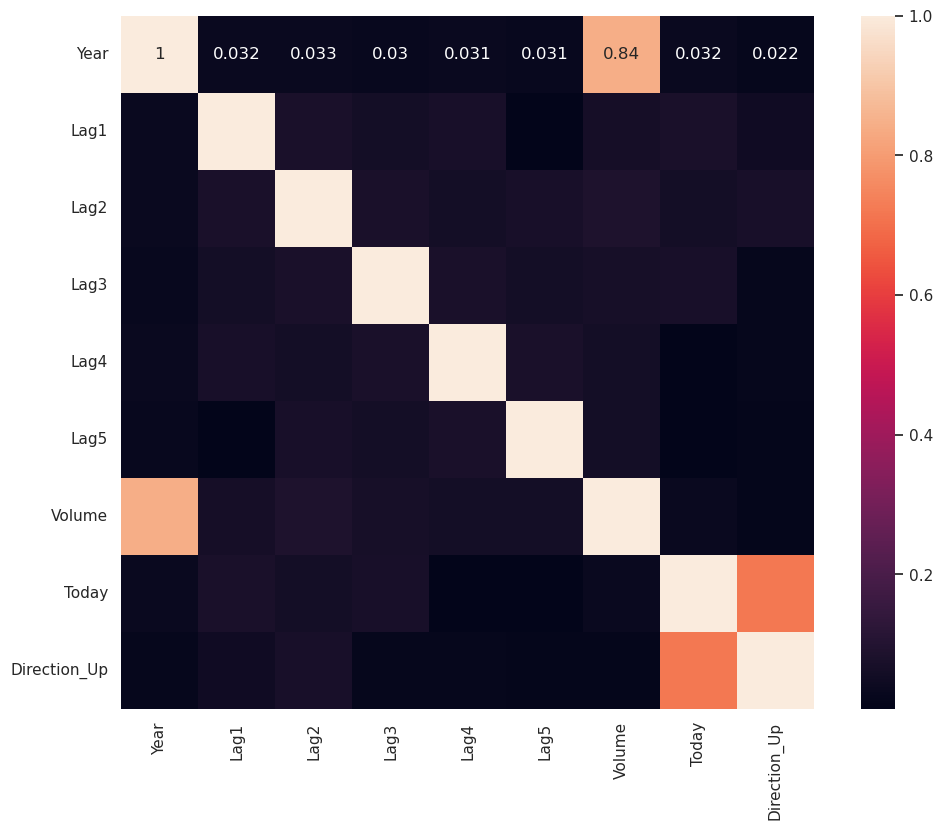

In [15]:
# Correlation matrix
corr_matrix = weekly_df.corr().abs()
fig, ax     = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
f_10b = 'Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'


model_10b = smf.logit.formula.api(formula=f_10b, data=weekly_df).fit()
# Display model summary
display(f_10b.summary())
# Do any of the predictors appear to be statistically significant?
display(HTML('<h3>Statistically significant predictors:</h3>'))
display(pd.DataFrame({'p>|z|': model_10b.pvalues[model_10b.pvalues < 0.05].drop('Intercept')}))

In [17]:
# Clarifying orientation of confusion matrix
# Here we see that 
# - rows i represent true values
# - columns j represent predictions


y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

confusion_matrix(y_true, y_pred)

array([[2, 0],
       [1, 3]])

In [ ]:
def confusion_table(confusion_matrix):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})

In [129]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
lda = LinearDiscriminantAnalysis()
model_10e = lda.fit(X_train, y_train)

# Predict
y_pred_lda = model_10e.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_lda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
lda_stats = classifier_stats(confusion_mtx)
lda_stats

NameError: name 'positive_observations' is not defined

In [66]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
qda = QuadraticDiscriminantAnalysis()
model_10f = qda.fit(X_train, y_train)
y_pred_qda = model_10f.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_qda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
qda_stats = classifier_stats(confusion_mtx)
qda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,0,43,43
y=1,0,61,61
Total,0,104,


/tmp/ipykernel_1276/292096118.py:50: RuntimeWarning: invalid value encountered in scalar divide
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


prior_error_rate                         0.413462
total_error_rate                         0.413462
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.586538
negative_predictive_value                     NaN
dtype: float64

In [68]:
from sklearn.neighbors import KNeighborsClassifier

# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = preprocessing.scale(np.array(weekly_df_train['Lag2']).reshape(-1,1))
X_test  = preprocessing.scale(np.array(weekly_df_test['Lag2']).reshape(-1,1))
y_train = np.array(weekly_df_train['Direction_Up'])
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_train)

# Model
K = 1
model_10g = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
y_pred_knn = model_10g.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - total_error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
knn_stats = classifier_stats(confusion_mtx)
knn_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,18,25,43
y=1,27,34,61
Total,45,59,


prior_error_rate                         0.413462
total_error_rate                         0.500000
true_positive_rate (sensitivity)         0.557377
false_negative_rate                      0.442623
false_positive_rate                      0.581395
true_negative_rate (specificity)         0.418605
positive_predictive_value (precision)    0.576271
negative_predictive_value                0.400000
dtype: float64

In [117]:
auto_df = pd.read_csv('Auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()

# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'],
             'qual': ['name']}

quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

# Add mpg01 feature
mpg01   = (auto_df['mpg'] > auto_df['mpg'].median()).astype(np.float64)
auto_df = pd.concat([auto_df, mpg01.rename('mpg01')], axis=1).drop('mpg', axis=1)
auto_df.head()

display(auto_df.head())

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

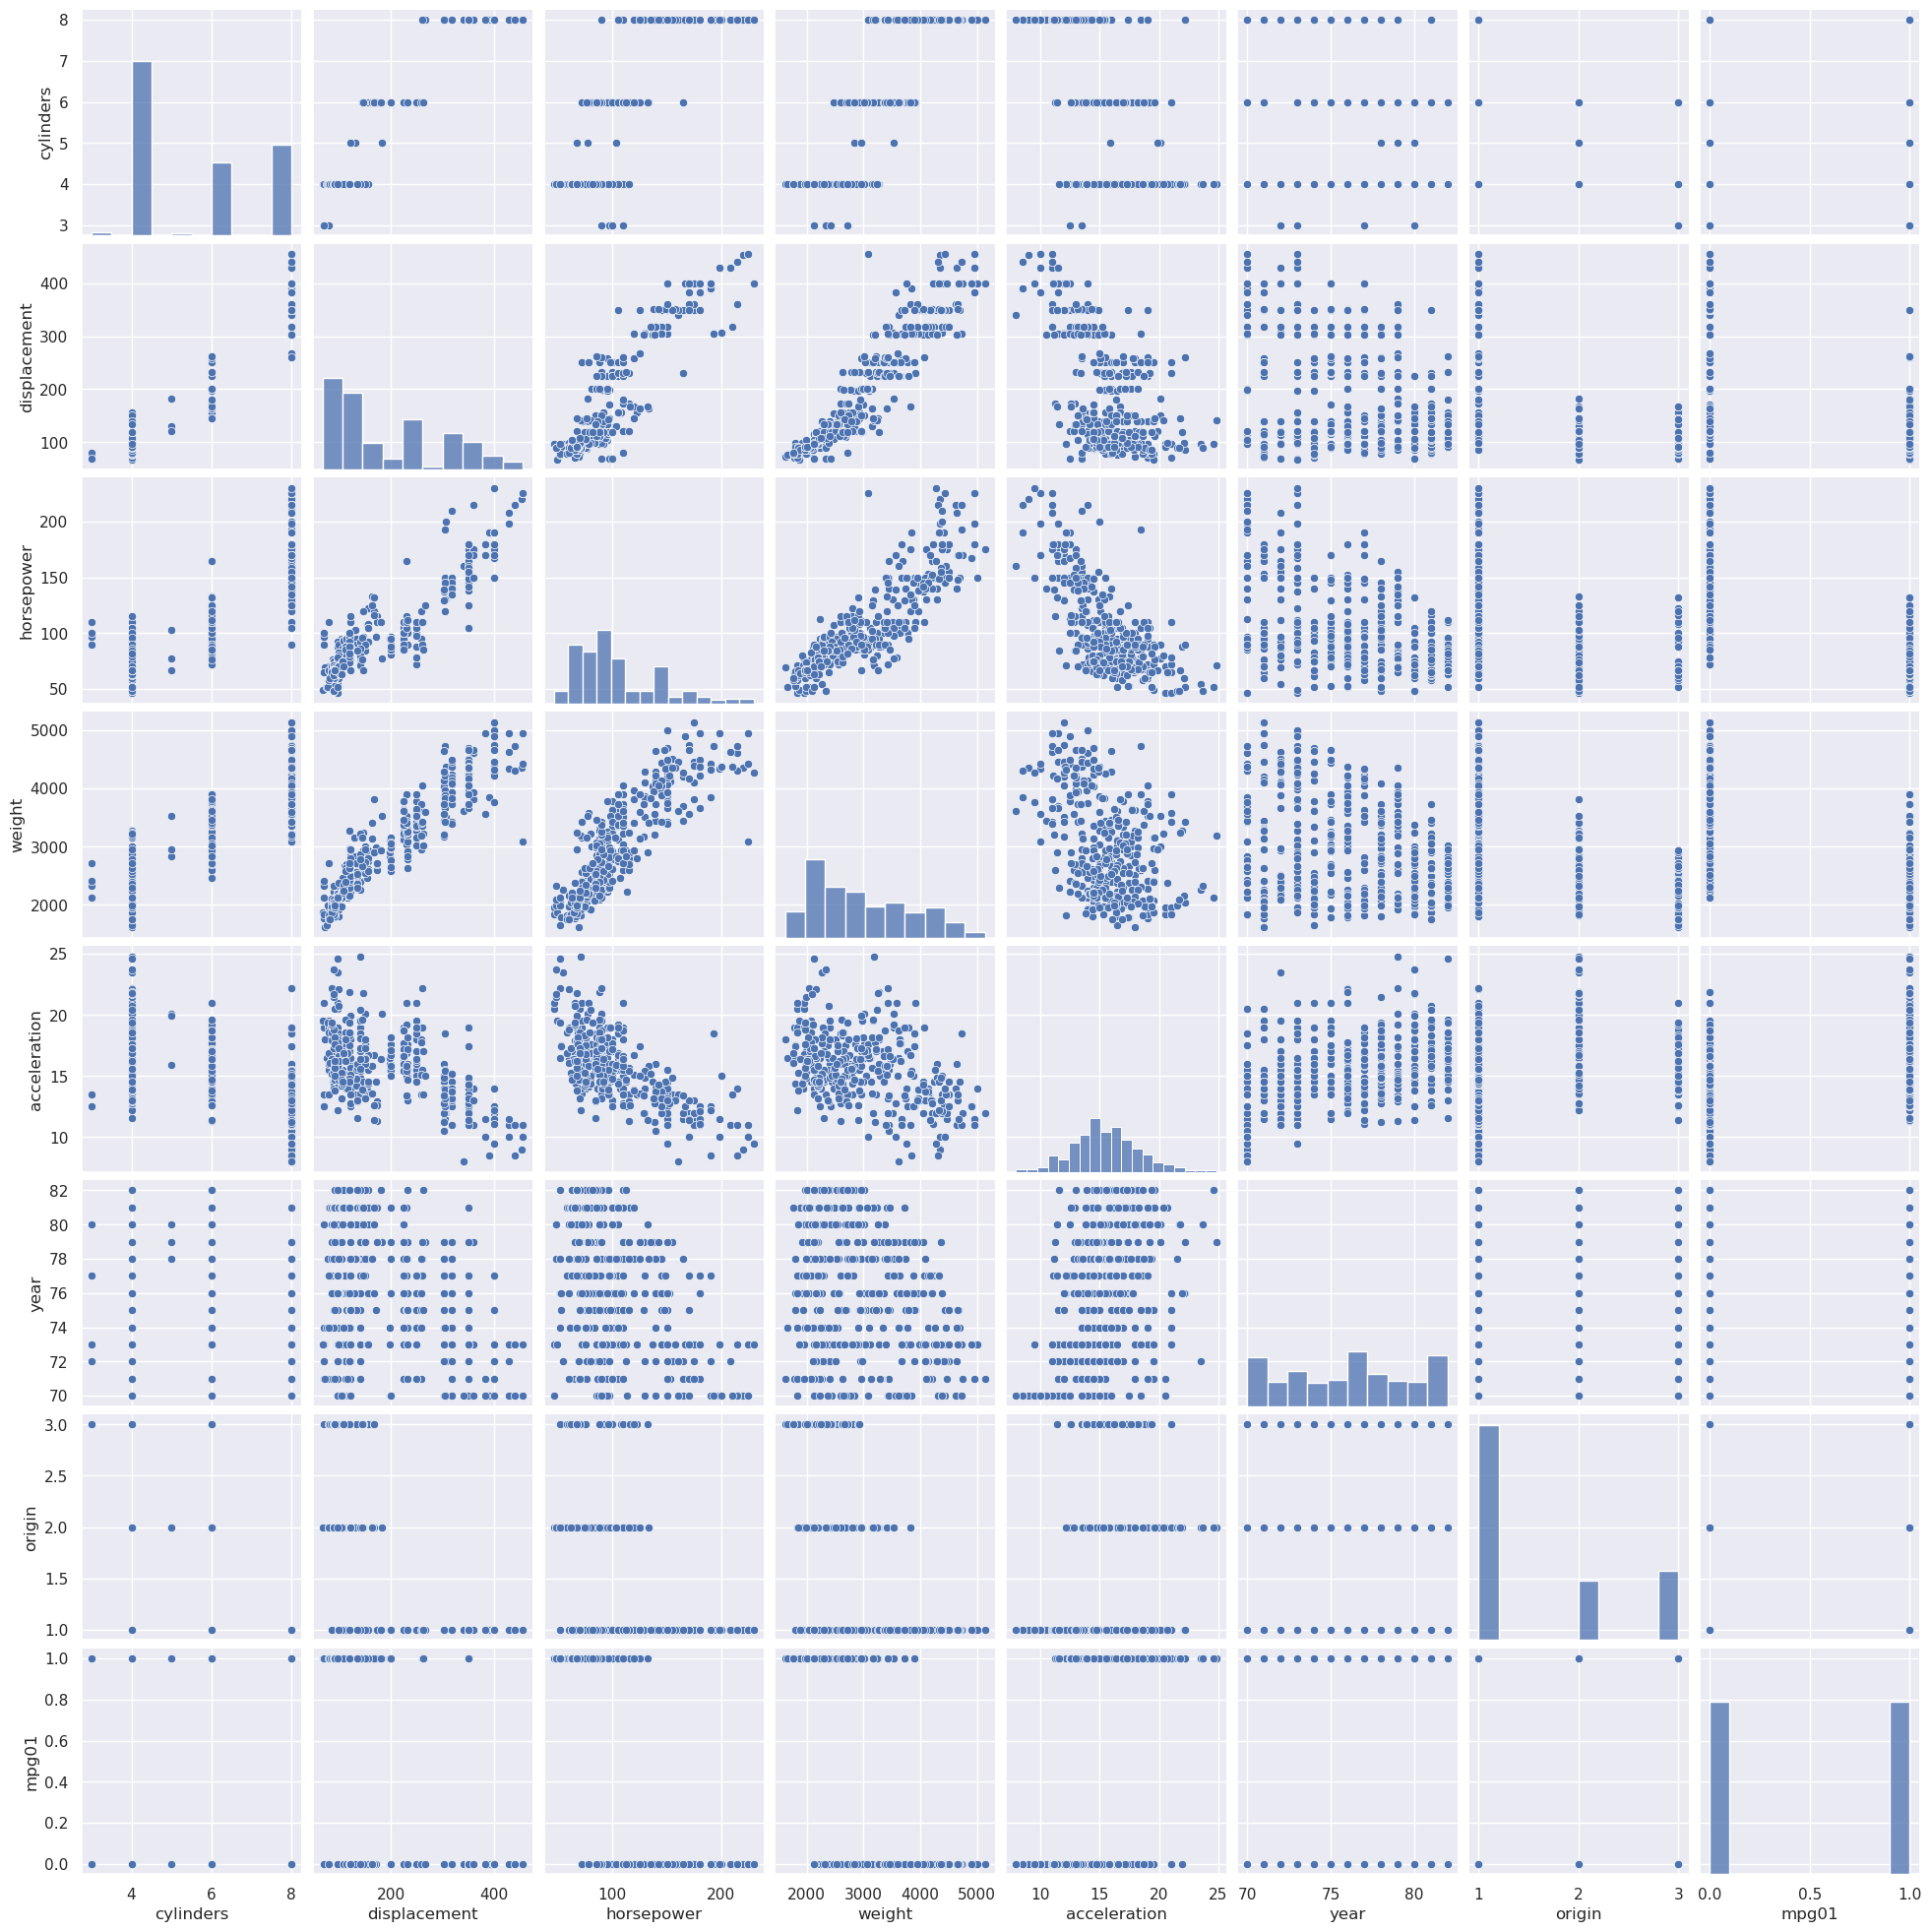

In [78]:
sns.pairplot(auto_df);



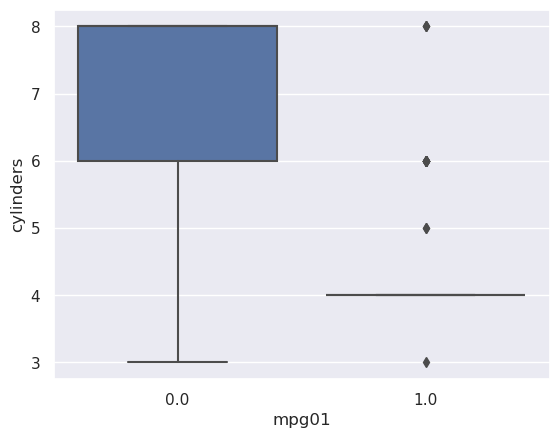

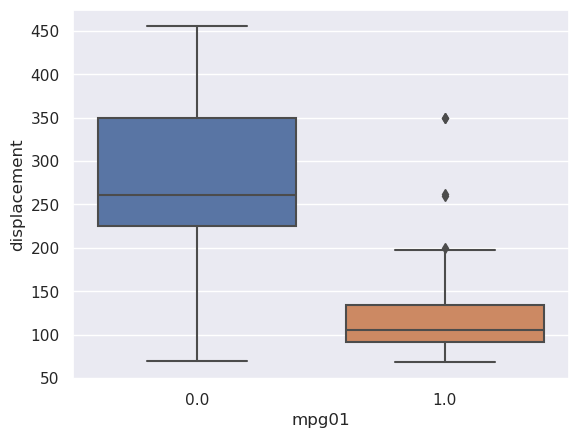

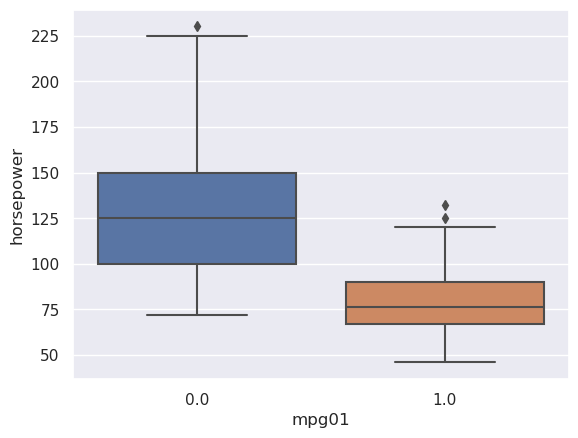

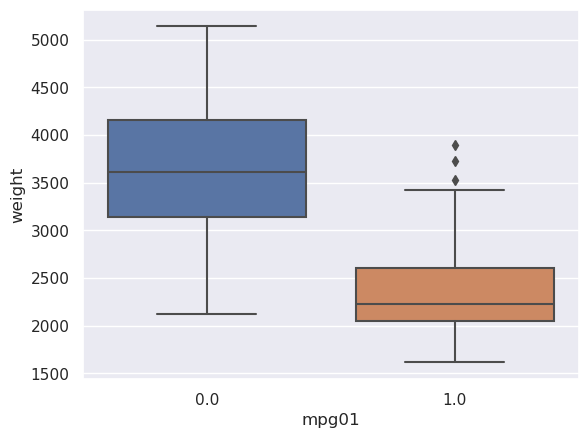

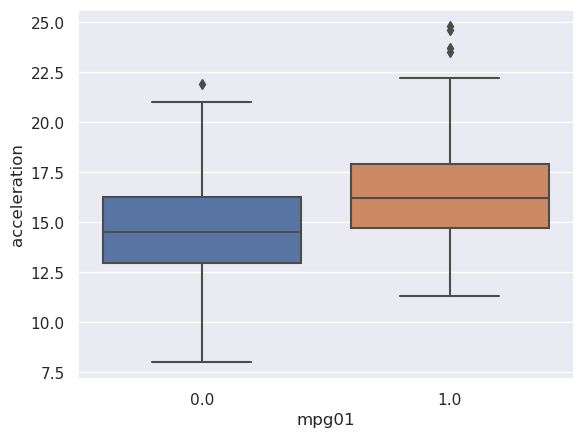

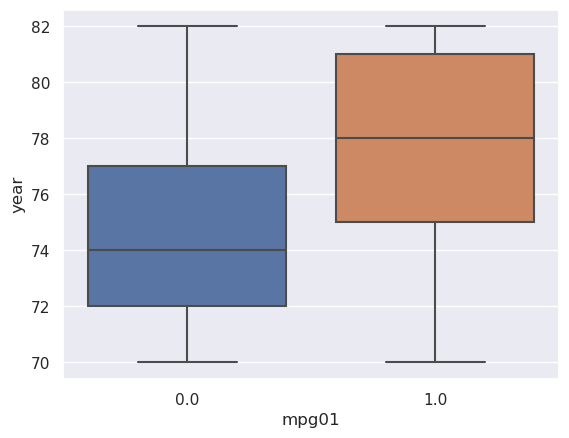

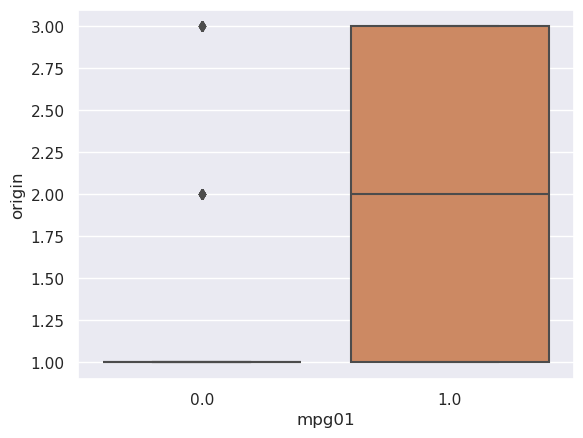

In [79]:
for c in auto_df.columns.drop(['mpg01', 'name']):
    sns.boxplot(x=auto_df['mpg01'], y=auto_df[c])
    plt.show();

In [90]:
# Create index for training set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

# Training set (70%)
display(HTML('<h3>Training set</h3>'))
display(auto_df[train].head())

# Test set (30%)
display(HTML('<h3>Test set</h3>'))
display(auto_df[~train].head())


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0
5,8.0,429.0,198.0,4341.0,10.0,70.0,1.0,ford galaxie 500,0.0


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
13,8.0,455.0,225.0,3086.0,10.0,70.0,1.0,buick estate wagon (sw),0.0
20,4.0,110.0,87.0,2672.0,17.5,70.0,2.0,peugeot 504,1.0
21,4.0,107.0,90.0,2430.0,14.5,70.0,2.0,audi 100 ls,1.0
24,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin,0.0


In [92]:
# Create index for training set
np.random.seed(1)
train_idx = np.random.rand(len(auto_df)) < 0.7
auto_df_train = auto_df[train_idx]
auto_df_test  = auto_df[~train_idx]

In [94]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)


models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda}
scaled = []


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))

,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,4,50,54
Total,60,60,


prior_error_rate                         0.550000
total_error_rate                         0.116667
true_positive_rate (sensitivity)         0.925926
false_negative_rate                      0.074074
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.833333
negative_predictive_value                0.933333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,10,66
y=1,2,52,54
Total,58,62,


prior_error_rate                         0.550000
total_error_rate                         0.100000
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.151515
true_negative_rate (specificity)         0.848485
positive_predictive_value (precision)    0.838710
negative_predictive_value                0.965517
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


prior_error_rate                         0.550000
total_error_rate                         0.091667
true_positive_rate (sensitivity)         0.962963
false_negative_rate                      0.037037
false_positive_rate                      0.136364
true_negative_rate (specificity)         0.863636
positive_predictive_value (precision)    0.852459
negative_predictive_value                0.966102
dtype: float64

In [96]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
    # Predict
    y_pred = model.predict(preprocessing.scale(X_test))
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,62,4,66
y=1,7,47,54
Total,69,51,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,3,51,54
Total,62,58,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,59,7,66
y=1,2,52,54
Total,61,59,


total_error_rate: 
0.07499999999999996


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,58,8,66
y=1,2,52,54
Total,60,60,


total_error_rate: 
0.08333333333333337


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


,y_pred=0,y_pred=1,Total
,,,
y=0,57,9,66
y=1,2,52,54
Total,59,61,


total_error_rate: 
0.09166666666666667


In [103]:
def Power(x, a):
    return np.power(x, a)